In [1]:
import torch
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
from sklearn import model_selection
from toolbox_02450 import rlr_validate, train_neural_net, draw_neural_net, visualize_decision_boundary

### One-hot-encoding for categorical attributes

In [2]:
# Read file and store as pandas dataframe
filename = '../Data/day.csv'
df = pd.read_csv(filename)

for attribute in ['instant','dteday','yr','mnth','holiday','weekday','casual','registered']:
    df = df.drop(attribute, axis=1)
    
# One hot encoding
ohe_df = pd.get_dummies(df, columns = ['season','weathersit'])
ohe_df = ohe_df.drop(['season_4','weathersit_3'], axis=1)    # season_4, weathersit_3 are chosen as reference variables
display(ohe_df)

,workingday,temp,atemp,hum,windspeed,cnt,season_1,season_2,season_3,weathersit_1,weathersit_2
0,0,0.344167,0.363625,0.805833,0.160446,985,1,0,0,0,1
1,0,0.363478,0.353739,0.696087,0.248539,801,1,0,0,0,1
2,1,0.196364,0.189405,0.437273,0.248309,1349,1,0,0,1,0
3,1,0.200000,0.212122,0.590435,0.160296,1562,1,0,0,1,0
4,1,0.226957,0.229270,0.436957,0.186900,1600,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
726,1,0.254167,0.226642,0.652917,0.350133,2114,1,0,0,0,1
727,1,0.253333,0.255046,0.590000,0.155471,3095,1,0,0,0,1
728,0,0.253333,0.242400,0.752917,0.124383,1341,1,0,0,0,1
729,0,0.255833,0.231700,0.483333,0.350754,1796,1,0,0,1,0


### Standardize data

In [3]:
N, M = ohe_df.shape
attribute_names = list(ohe_df.columns)

# Get column indexes
temp_col = ohe_df.columns.get_loc("temp")
atemp_col = ohe_df.columns.get_loc("atemp")
hum_col = ohe_df.columns.get_loc("hum")
wspd_col = ohe_df.columns.get_loc("windspeed")
cnt_col = ohe_df.columns.get_loc("cnt")

# Undo the original max-min normalization
data = ohe_df.values
for row in range(0, N):
    data[row, temp_col] = data[row, temp_col]*(39-(-8)) + (-8)
    data[row, atemp_col] = data[row, atemp_col]*(50-(-16)) + (-16)
    data[row, hum_col] = data[row, hum_col]*100
    data[row, wspd_col] = data[row, wspd_col]*67

# Standarize ratio data attributes
for col in range(temp_col, cnt_col+1): # subtract mean column-wise
    mn = data[:, col].mean(0)
    std = np.std(data[:, col])
    data[:, col] = (data[:, col] - np.ones(N)*mn)/std

# Create DataFrame for visualisation
data_df = pd.DataFrame(data, columns=attribute_names)
display(data_df)

,workingday,temp,atemp,hum,windspeed,cnt,season_1,season_2,season_3,weathersit_1,weathersit_2
0,0.0,-0.826662,-0.679946,1.250171,-0.387892,-1.817953,1.0,0.0,0.0,0.0,1.0
1,0.0,-0.721095,-0.740652,0.479113,0.749602,-1.912999,1.0,0.0,0.0,0.0,1.0
2,1.0,-1.634657,-1.749767,-1.339274,0.746632,-1.629925,1.0,0.0,0.0,1.0,0.0
3,1.0,-1.614780,-1.610270,-0.263182,-0.389829,-1.519898,1.0,0.0,0.0,1.0,0.0
4,1.0,-1.467414,-1.504971,-1.341494,-0.046307,-1.500269,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
726,1.0,-1.318665,-1.521108,0.175807,2.061426,-1.234757,1.0,0.0,0.0,0.0,1.0
727,1.0,-1.323224,-1.346690,-0.266238,-0.452131,-0.728012,1.0,0.0,0.0,0.0,1.0
728,0.0,-1.323224,-1.424344,0.878392,-0.853552,-1.634057,1.0,0.0,0.0,0.0,1.0
729,0.0,-1.309558,-1.490049,-1.015664,2.069444,-1.399023,1.0,0.0,0.0,1.0,0.0


### Set 'cnt' as target variable

In [5]:
# Split dataset into features and target vector
cnt_col = attribute_names.index("cnt")
y = data[:,cnt_col]
X = np.delete(data, cnt_col, axis=1)
attribute_names.pop(cnt_col)
N, M = X.shape

# Add offset attribute
X = np.concatenate((np.ones((X.shape[0],1)),X),1)
attribute_names = [u'Offset']+attribute_names
M = M+1

print("N: {}, M: {} (including offset)".format(N,M))

N: 731, M: 11 (including offset)


In [6]:
attribute_names

['Offset',
 'workingday',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'season_1',
 'season_2',
 'season_3',
 'weathersit_1',
 'weathersit_2']

### 1. Regularized Linear Regression

In [7]:
# Values of lambda
lambdas = np.power(10.,np.linspace(-5,9,100))

### 2. Artificial Neural Network

In [8]:
# Define the ANN model structure
n_hidden_units = 3
n_replicates = 1        # number of networks trained in each k-fold
max_iter = 15000

model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units), #M features to H hiden units
                    # 1st transfer function, either Tanh or ReLU:
                    torch.nn.Tanh(),                            #torch.nn.ReLU(),
                    torch.nn.Linear(n_hidden_units, 1) # H hidden units to 1 output neuron
#                     torch.nn.Sigmoid() # final tranfer function
                    )
loss_fn = torch.nn.MSELoss()
print('Training model of type:\n\n{}\n'.format(str(model())))

Training model of type:

Sequential(
  (0): Linear(in_features=11, out_features=3, bias=True)
  (1): Tanh()
  (2): Linear(in_features=3, out_features=1, bias=True)
)



### Cross Validation

In [9]:
# Cross validation
K = 5
internal_cross_validation = 5
CV = model_selection.KFold(K, shuffle=False)

# Initialize variables
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_rlr = np.empty((K,1))
Error_test_rlr = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))
Error_test_ANN = np.empty((K,1))

opt_h = np.zeros((K,1))                   # optimal ANN hidden units for each outer fold
opt_lambdas = np.empty((K,1))             # optimal lambdas for each outer fold
w_rlr = np.empty((M,K))                   # weights for each attribute with regularisation
w_noreg = np.empty((M,K))                 # weights for each attribute without regularisation
mu = np.empty((K, M-1))
sigma = np.empty((K, M-1))

### Training and Testing


Crossvalidation fold: 1/5

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.38855422	0.000114654176
		2000	0.34956938	6.0867926e-05
		3000	0.3360219	3.148453e-05
		4000	0.32802194	1.580846e-05
		5000	0.32428634	9.006242e-06
		6000	0.32162234	7.96891e-06
		7000	0.31932443	5.9730387e-06
		8000	0.31695494	6.5818467e-06
		9000	0.3154159	3.6849326e-06
		10000	0.31453824	2.0844834e-06
		Final loss:
		10403	0.31429428	9.48229e-07

	Best loss: 0.3142942786216736


Crossvalidation fold: 2/5

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.32308412	0.00016287502
		2000	0.2906928	5.9049016e-05
		3000	0.28173023	1.7453922e-05
		4000	0.277101	1.7315313e-05
		5000	0.2730178	9.27842e-06
		6000	0.27125686	5.2736136e-06
		7000	0.26995128	4.8575275e-06
		8000	0.26860926	5.2146447e-06
		9000	0.26711428	6.024821e-06
		10000	0.26564395	4.4875387e-06
		11000	0.26475522	2.5890015e-06
		12000	0.26417625	1.6921812e-06
		13000	0.2637549	1.355908e-06
		Final loss:
		13400	0.26361388	9.044227e-07

	Best loss: 0

Text(0.5, 1.0, 'Test mean-squared-error')

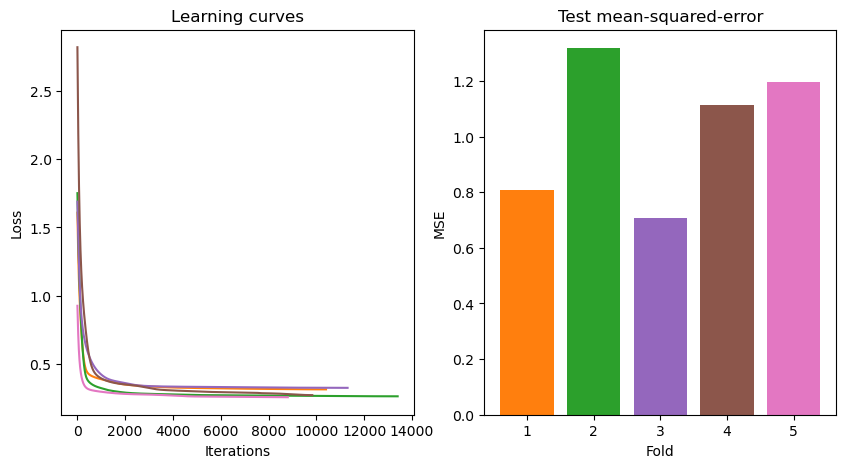

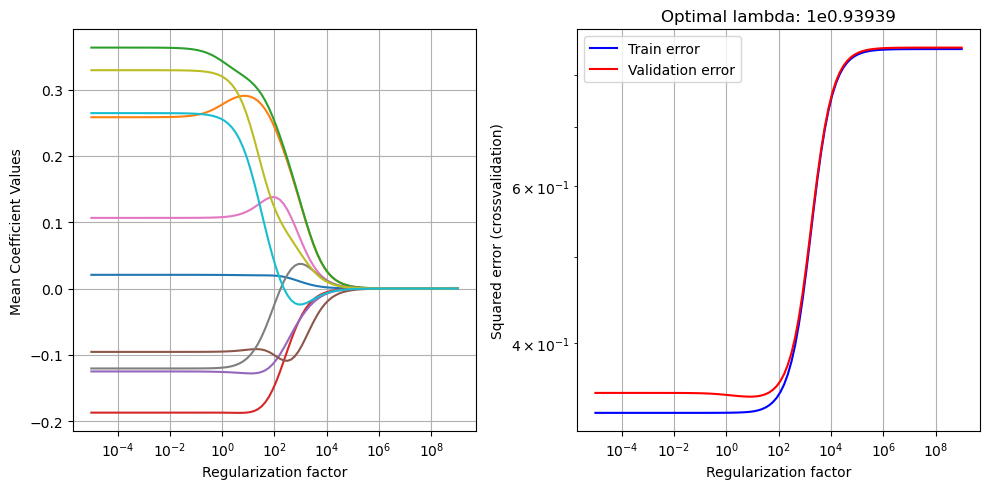

In [18]:
# Setup figure for display of ANN summaries
summaries, summaries_axes = plt.subplots(1, 2, figsize=(10,5),num=2)
color_list = ['tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink',
              'tab:gray', 'tab:olive', 'tab:cyan', 'tab:red', 'tab:blue']


for k, (train_index, test_index) in enumerate(CV.split(X,y)):
    print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K))

    ############################### Lingear Regression ###############################
    # Extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]

    opt_val_err,opt_lambdas[k],mean_w_vs_lambda,train_err_vs_lambda,test_err_vs_lambda = \
    rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    # Standardize outer fold based on training set, and save the mean and std
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)

    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :] ) / sigma[k, :]
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :] ) / sigma[k, :]

    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    # Compute mean squared error without using the input data
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum(axis=0)/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambdas[k] * np.eye(M)
    lambdaI[0,0] = 0 # Do no regularize the bias term
    w_rlr[:,k] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()

    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = np.square(y_train-X_train @ w_rlr[:,k]).sum(axis=0)/y_train.shape[0]
    y_est_rlr = X_test @ w_rlr[:,k]
    Error_test_rlr[k] = np.square(y_test-y_est_rlr).sum(axis=0)/y_test.shape[0]

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:,k] = np.linalg.solve(XtX,Xty).squeeze()

    # Compute mean squared error without regularization
    Error_train[k] = np.square(y_train-X_train @ w_noreg[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test[k] = np.square(y_test-X_test @ w_noreg[:,k]).sum(axis=0)/y_test.shape[0]

    ##################################### ANN #####################################
    # Extract test and train tensor sets to train ANN
    X_train = torch.Tensor(X[train_index,:])
    y_train = torch.Tensor(y[train_index]).reshape(-1,1)
    X_test = torch.Tensor(X[test_index,:])
    y_test = torch.Tensor(y[test_index]).reshape(-1,1)

    # Train the net
    net, final_loss, learning_curve = train_neural_net(model,
                                                       loss_fn,
                                                       X=X_train,
                                                       y=y_train,
                                                       n_replicates=n_replicates,
                                                       max_iter=max_iter)
    print('\n\tBest loss: {}\n'.format(final_loss))

    # Determine estimated values for test set
    y_test_est = net(X_test)
    # Determine errors
    se = (y_test_est.squeeze().float()-y_test.squeeze().float())**2         # squared error
    mse = (sum(se).type(torch.float)/len(y_test)).data.numpy()    # mean squared error
    Error_test_ANN[k] = mse                      # store error rate for current CV fold

    # Display the learning curve for the best net in the current fold
    h, = summaries_axes[0].plot(learning_curve, color=color_list[k])
    h.set_label('CV fold {0}'.format(k+1))
    summaries_axes[0].set_xlabel('Iterations')
    summaries_axes[0].set_ylabel('Loss')
    summaries_axes[0].set_title('Learning curves')

   # Display the results for the last cross-validation fold
    if k == K-1:
        reg_fig, reg_axes = plt.subplots(1, 2, figsize=(10,5),num=1)
        reg_axes[0].semilogx(lambdas,mean_w_vs_lambda.T[:,1:],'-') # Don't plot the bias term
        reg_axes[0].set_xlabel('Regularization factor')
        reg_axes[0].set_ylabel('Mean Coefficient Values')
        reg_axes[0].grid()

        reg_axes[1].set_title('Optimal lambda: 1e{0}'.format(round(np.log10(opt_lambdas[k][0]),5)))
        reg_axes[1].loglog(lambdas,train_err_vs_lambda.T,'b-',lambdas,test_err_vs_lambda.T,'r-')
        reg_axes[1].set_xlabel('Regularization factor')
        reg_axes[1].set_ylabel('Squared error (crossvalidation)')
        reg_axes[1].legend(['Train error','Validation error'])
        reg_axes[1].grid()
        reg_fig.tight_layout()

# Display the MSE across folds
summaries_axes[1].bar(np.arange(1, K+1), np.squeeze(np.asarray(Error_test_ANN)), color=color_list)
summaries_axes[1].set_xlabel('Fold')
summaries_axes[1].set_xticks(np.arange(1, K+1))
summaries_axes[1].set_ylabel('MSE')
summaries_axes[1].set_title('Test mean-squared-error')

### Results of Linear Regression

In [19]:
print('Linear regression without feature selection:')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print('Regularized linear regression:')
print('- Training error: {0}'.format(Error_train_rlr.mean()))
print('- Test error:     {0}'.format(Error_test_rlr.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_rlr.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test_rlr.sum())/Error_test_nofeatures.sum()))

Linear regression without feature selection:
- Training error: 0.3904521222638663
- Test error:     1.0380973117114254
- R^2 train:     0.5950584310666241
- R^2 test:     -1.417939877761705

Regularized linear regression:
- Training error: 0.39106683484219185
- Test error:     1.038972549193091
- R^2 train:     0.5944209068691196
- R^2 test:     -1.4199784839555138



Text(0.5, 1.0, 'Weights from each fold of Regularized Linear Regression')

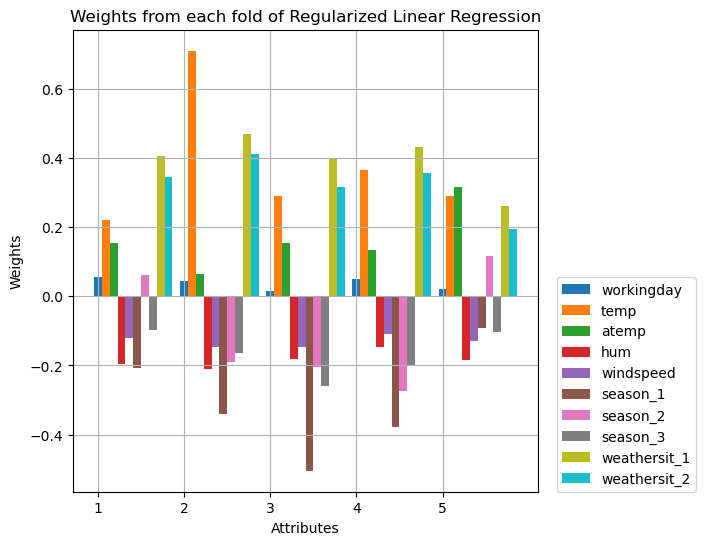

In [14]:
# Bar plot of RLR weights
weights = range(1,M)      # skip offset
bw = 1.0/(len(weights)+1)
r = np.arange(1,K+1)

plt.figure(figsize=(6,6), num=3)
for i in weights:
    plt.bar(r+i*bw, w_rlr[i,:], width=bw)
plt.xticks(r+bw, range(1,K+1))
plt.xlabel('Attributes')
plt.ylabel('Weights')
plt.legend(attribute_names[1:M+1], loc=(1.04, 0))
plt.grid()
plt.title('Weights from each fold of Regularized Linear Regression')

### Results of ANN

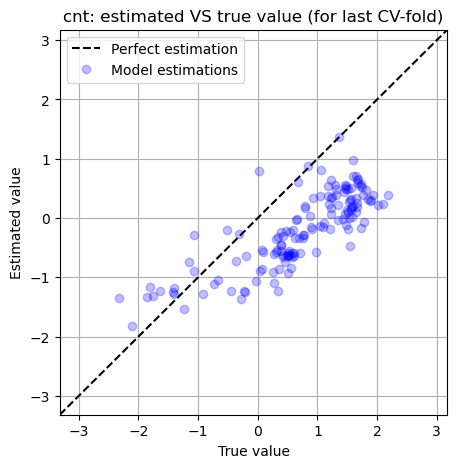

In [15]:
plt.figure(figsize=(5,5),num=5)
y_est = y_test_est.data.numpy().squeeze()
y_true = y_test.data.numpy().squeeze()
axis_range = [np.min([y_est, y_true])-1,np.max([y_est, y_true])+1]
plt.plot(axis_range,axis_range,'k--')           # perfect estimation
plt.plot(y_true, y_est,'ob',alpha=.25)          # ANN estimation
plt.legend(['Perfect estimation','Model estimations'])
plt.title('cnt: estimated VS true value (for last CV-fold)')
plt.ylim(axis_range)
plt.xlim(axis_range)
plt.xlabel('True value')
plt.ylabel('Estimated value')
plt.grid()

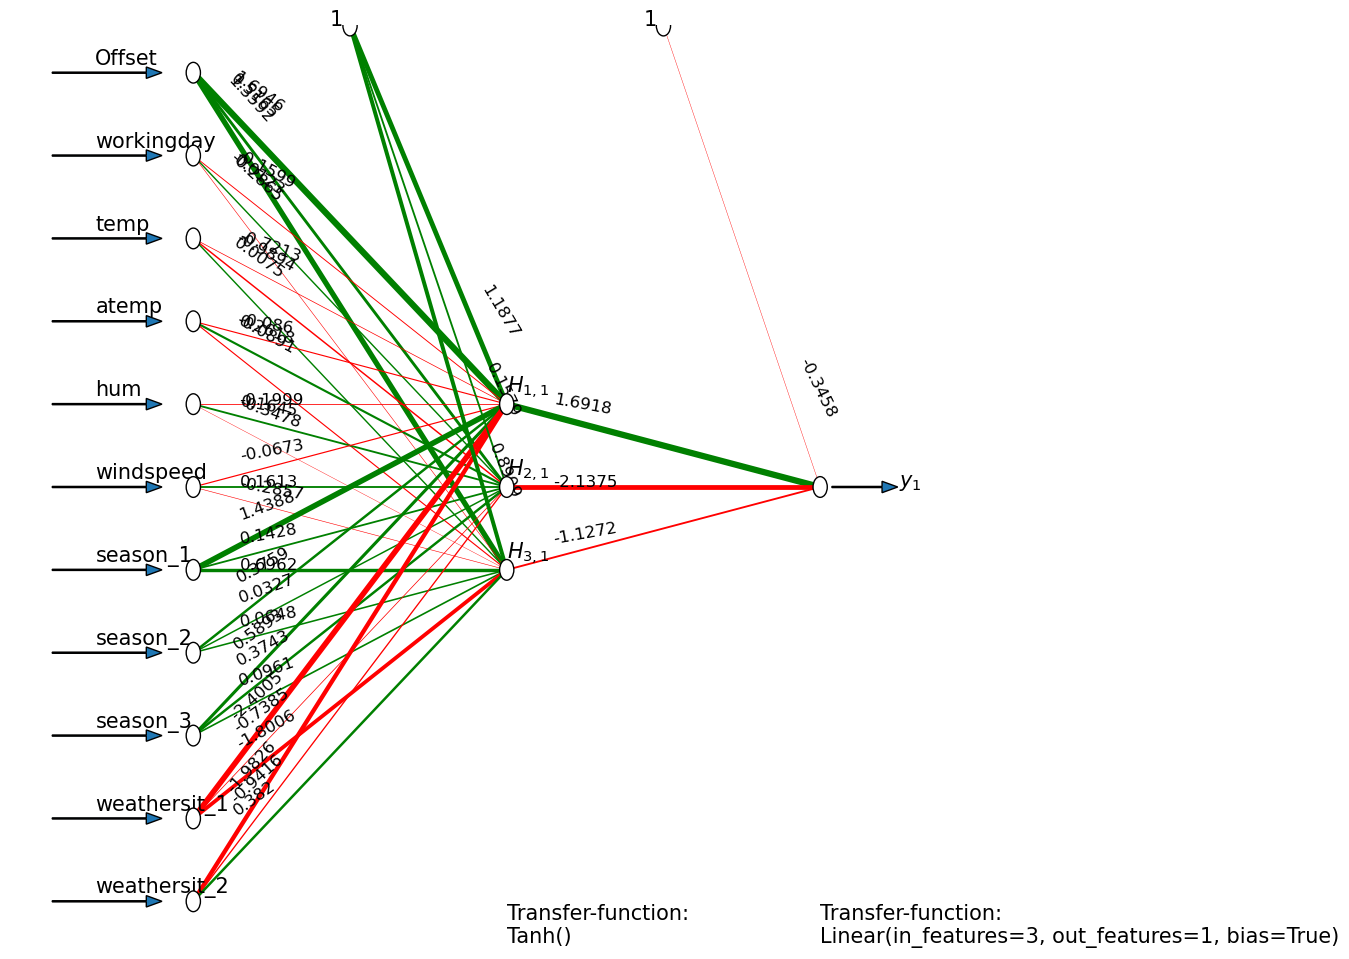

In [16]:
# Diagram of best neural net in last fold
weights = [net[i].weight.data.numpy().T for i in [0,2]]
biases = [net[i].bias.data.numpy() for i in [0,2]]
tf =  [str(net[i]) for i in [1,2]]
draw_neural_net(weights, biases, tf, attribute_names=attribute_names)

plt.show()

### Table 2

In [17]:
print("Outer fold \tANN \t\t\tLinear Regression \t\tBaseline")
print("--------------------------------------------------------------------------------")
print("i \t\th∗_i \tEtest_i \tlambda_i \tEtest_i \tEtest_i")
for i in range(K):
    print("{} \t\t{:.3f} \t{:.3f} \t\t{:.2e} \t{:.3f} \t\t{:.3f}".format(\
        i+1,opt_h[i][0],Error_test_ANN[i].item(),opt_lambdas[i][0],\
            Error_test_rlr[i][0],Error_test_nofeatures[i][0]))

Outer fold 	ANN 			Linear Regression 		Baseline
--------------------------------------------------------------------------------
i 		h∗_i 	Etest_i 	lambda_i 	Etest_i 	Etest_i
1 		0.000 	0.832 		8.70e+00 	0.800 		0.434
2 		0.000 	1.235 		4.64e-01 	1.320 		0.173
3 		0.000 	0.667 		8.70e+00 	0.610 		0.272
4 		0.000 	1.141 		8.70e+00 	1.114 		0.327
5 		0.000 	1.170 		1.20e+01 	1.334 		0.941
